# Использование библиотек gpxpy, geotiler - исследование GPS трека
Предварительно была совершена прогулка, записан маршрут, но геопозиция частенько сбивалась

In [10]:
!pip install gpxpy # необходимые библиотеки
!pip install geopy
!pip install geotiler

import pandas as pd
import numpy as np
import matplotlib.pyplot as pt
import gpxpy
import io
from geopy import distance
import geotiler as gt

### Прочтение файла и преобразование его в набор данных pandas со столбцами latitude, longitude, elevation, timestamp

In [5]:
with open("Friday Night Walk.gpx", 'r', encoding='utf-8') as gpx_file:
    gpx_data = gpxpy.parse(gpx_file)

my_list = []
for track in gpx_data.tracks:
    for segment in track.segments:
        for point in segment.points:
            my_list.append({
                'latitude': point.latitude,
                'longitude': point.longitude,
                'elevation': point.elevation,
                'timestamp': point.time
            })

walk = pd.DataFrame(my_list)

print(walk.head())

    latitude  longitude   elevation                 timestamp
0  55.753494  37.611264  153.129089 2024-10-18 18:26:23+00:00
1  55.753464  37.611282  153.129089 2024-10-18 18:26:23+00:00
2  55.753643  37.611388  153.129089 2024-10-18 18:27:08+00:00
3  55.754017  37.611787  153.129089 2024-10-18 18:27:49+00:00
4  55.754337  37.612127  153.129089 2024-10-18 18:27:49+00:00


### Расстояние для каждой пары соседних точек

In [8]:
between = [0] # начальное значение, фактически для нулевой точки
for i in range(1, len(walk)):
    start = (walk.loc[i-1, 'latitude'], walk.loc[i-1, 'longitude']) # координата начальной точки
    end = (walk.loc[i, 'latitude'], walk.loc[i, 'longitude']) # координата конечной точки
    between.append(distance.distance(start, end).m) # вычисляем расстояние и добавляем его в список в метрах
walk['dist'] = between
print (walk['dist'])

0       0.000000
1       3.487442
2      21.033877
3      48.605089
4      41.495267
         ...    
152     7.310467
153     3.052058
154     9.083120
155    36.747091
156    13.022997
Name: dist, Length: 157, dtype: float64


### Для каждой пары соседних точек посчитано,сколько секунд прошло между ними

In [13]:
walk['deltat'] = walk['timestamp'].diff().dt.total_seconds()
    #diff - разница между каждой временной меткой и предыдущей
    #dt.total_seconds() - всё в секунды
print (walk['deltat'])

0       NaN
1       0.0
2      45.0
3      41.0
4       0.0
       ... 
152     6.0
153     7.0
154    19.0
155     9.0
156     9.0
Name: deltat, Length: 157, dtype: float64


### Темп бега или прогулки на каждом из отрезков
##### 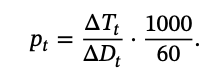

In [19]:
walk['pace'] = (walk['deltat'] / walk['dist']) * 1000 / 60
print (walk)

      latitude  longitude   elevation                 timestamp       dist  \
0    55.753494  37.611264  153.129089 2024-10-18 18:26:23+00:00   0.000000   
1    55.753464  37.611282  153.129089 2024-10-18 18:26:23+00:00   3.487442   
2    55.753643  37.611388  153.129089 2024-10-18 18:27:08+00:00  21.033877   
3    55.754017  37.611787  153.129089 2024-10-18 18:27:49+00:00  48.605089   
4    55.754337  37.612127  153.129089 2024-10-18 18:27:49+00:00  41.495267   
..         ...        ...         ...                       ...        ...   
152  55.759980  37.613511  149.087418 2024-10-18 19:12:51+00:00   7.310467   
153  55.759964  37.613472  149.127426 2024-10-18 19:12:58+00:00   3.052058   
154  55.759915  37.613356  149.052032 2024-10-18 19:13:17+00:00   9.083120   
155  55.759698  37.612914  149.074387 2024-10-18 19:13:26+00:00  36.747091   
156  55.759619  37.612761  151.863113 2024-10-18 19:13:35+00:00  13.022997   

     deltat       pace  
0       NaN        NaN  
1       0.0  

### Ряд накопленных с начала прогулки расстояний

In [22]:
walk['cumdist'] = np.cumsum(walk['dist'])
print (walk)

      latitude  longitude   elevation                 timestamp       dist  \
0    55.753494  37.611264  153.129089 2024-10-18 18:26:23+00:00   0.000000   
1    55.753464  37.611282  153.129089 2024-10-18 18:26:23+00:00   3.487442   
2    55.753643  37.611388  153.129089 2024-10-18 18:27:08+00:00  21.033877   
3    55.754017  37.611787  153.129089 2024-10-18 18:27:49+00:00  48.605089   
4    55.754337  37.612127  153.129089 2024-10-18 18:27:49+00:00  41.495267   
..         ...        ...         ...                       ...        ...   
152  55.759980  37.613511  149.087418 2024-10-18 19:12:51+00:00   7.310467   
153  55.759964  37.613472  149.127426 2024-10-18 19:12:58+00:00   3.052058   
154  55.759915  37.613356  149.052032 2024-10-18 19:13:17+00:00   9.083120   
155  55.759698  37.612914  149.074387 2024-10-18 19:13:26+00:00  36.747091   
156  55.759619  37.612761  151.863113 2024-10-18 19:13:35+00:00  13.022997   

     deltat       pace      cumdist  
0       NaN        NaN   

### Визуализация: высота над уровнем моря и темп прогулки

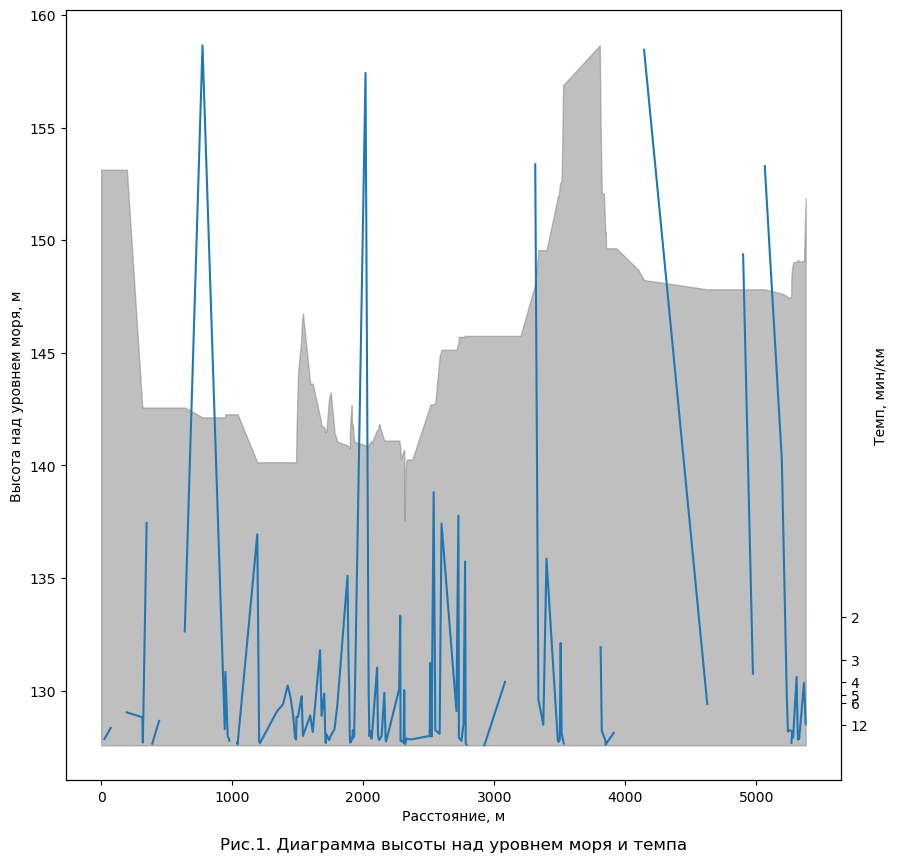

In [25]:
fig, ax1 = pt.subplots(figsize = (10, 10))
ax2 = ax1.twinx() # две оси

# высота
ax1.fill_between(walk['cumdist'], walk['elevation'], walk['elevation'].min() - 10, alpha=0.5, color = 'grey')
    #ax1.fill_between: заполнение области
    #walk['elevation'].min() - 10: нижная граница заполненной области
    #alpha: прозрачность
    #color: цвет

# темп
ax2.plot(walk['cumdist'], 1 / walk['pace']) #график для 1/pace
ax2.set_yticks([1/12, 1/6, 1/5, 1/4, 1/3, 1/2])
ax2.set_yticklabels([12, 6, 5, 4, 3, 2])

ax2.set_ylabel('Темп, мин/км')
ax1.set_xlabel('Расстояние, м')
ax1.set_ylabel('Высота над уровнем моря, м')
pt.title('Рис.1. Диаграмма высоты над уровнем моря и темпа', y = -0.1)

pt.show()
# максимально странные данные из-за сбоев геопозиции

### Сглаживание 
Даже если бы данные были более качественными, мы бы всё равно столкнулись с тем, что они бы по скорости движения и высоте были бы шумные. Это из-за того, что GPS измеряет местоположение со случайной ошибкой, влияние которой усиливается, когда мы берем приращения. Чтобы уменьшить шум, рассмотрим сглаженные ряды высоты над уровнем моря и темпа через скользящее среднее

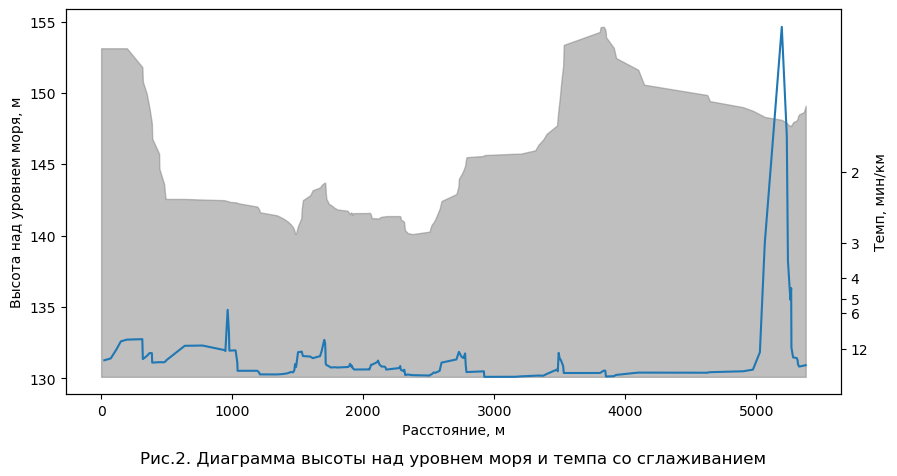

In [30]:
walk['pace2'] = walk['pace'].rolling(10, min_periods=1).mean()
walk['elevation2'] = walk['elevation'].rolling(10, min_periods=1).mean()

ig, ax1 = pt.subplots(figsize = (10, 5))
ax2 = ax1.twinx() #две оси

# высота
ax1.fill_between(walk['cumdist'], walk['elevation2'], walk['elevation2'].min() - 10, alpha=0.5, color = 'grey')

# темп
ax2.plot(walk['cumdist'], 1 / walk['pace2']) #график для 1/pace
ax2.set_yticks([1/12, 1/6, 1/5, 1/4, 1/3, 1/2])
ax2.set_yticklabels([12, 6, 5, 4, 3, 2])

ax2.set_ylabel('Темп, мин/км')
ax1.set_xlabel('Расстояние, м')
ax1.set_ylabel('Высота над уровнем моря, м')
pt.title('Рис.2. Диаграмма высоты над уровнем моря и темпа со сглаживанием', y = -0.2)

pt.show()

# данные уже гораздо лучше. основная проблема была как раз в самом конце прогулки; 
# лучше было бы на последние минут 7 вообще не обращать внимания

### Траектория движения на карте

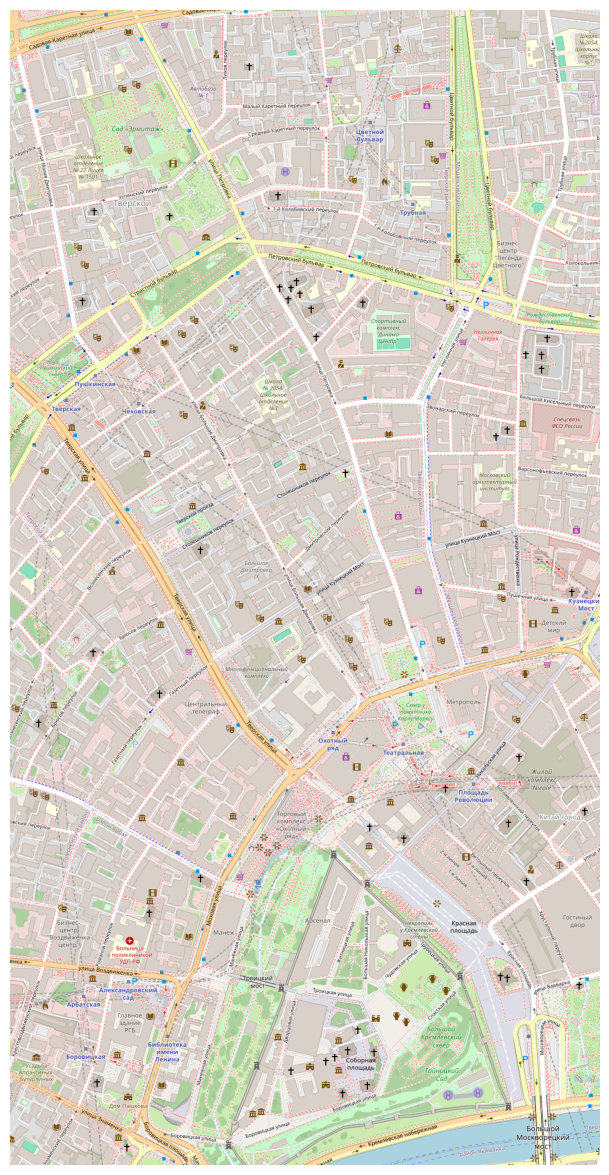

In [32]:
import nest_asyncio as na

na.apply()

# границы карты на основе данных 
min_lon = min(walk["longitude"])
max_lon = max(walk["longitude"])
min_lat = min(walk["latitude"])
max_lat = max(walk["latitude"])

# создание карты с найденными границами и уровнем зума
padding = 0.005
mmap = gt.Map(extent=(min_lon - padding, min_lat - padding, max_lon + padding, max_lat + padding), zoom=16)

img = gt.render_map(mmap)

pt.figure(figsize=(15, 15))
pt.imshow(img)
pt.axis('off')
pt.show()

### Перекодирование GPS-координат прогулки в координаты диаграммы

In [38]:
x = []
y = []
for i, j in zip(walk['longitude'], walk['latitude']):
    x_current, y_current = mmap.rev_geocode((i, j))
    x.append(x_current)
    y.append(y_current)
print (x[:5])

[330.95497091300786, 331.78846710920334, 336.72724048793316, 355.329691529274, 371.1482834313065]


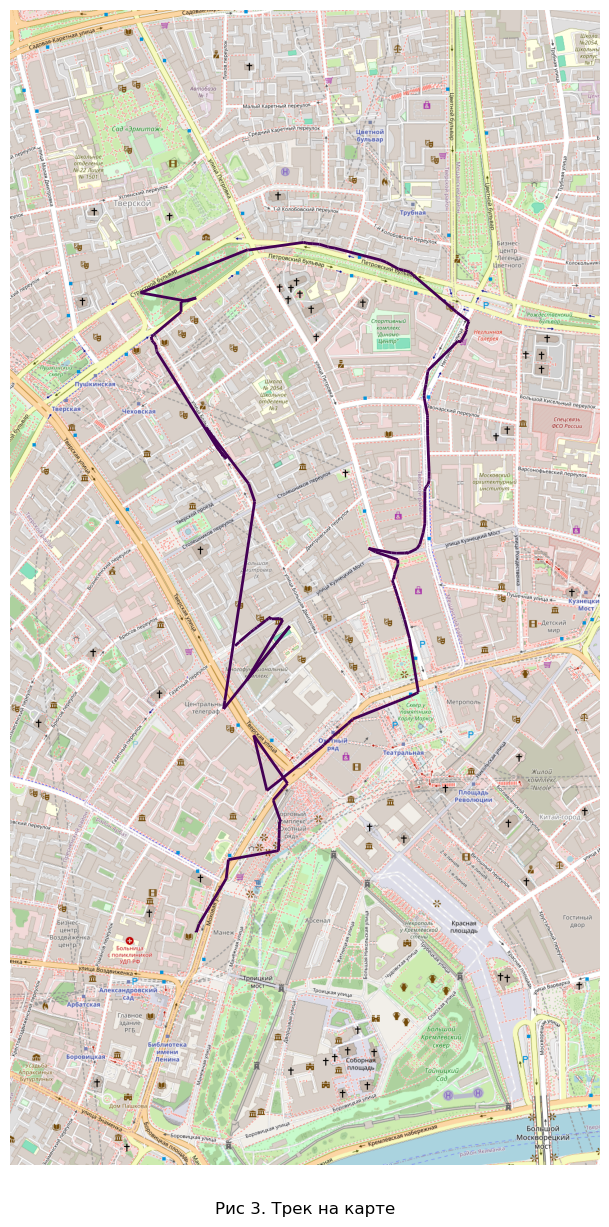

In [48]:
from matplotlib.collections import LineCollection

walk[['coord_lat', 'coord_lon']] = walk[['longitude', 'latitude']].apply(mmap.rev_geocode, 1, result_type='expand')
walk[['pace2']] = walk[['pace2']].fillna(0)
walk[['coord_lat', 'coord_lon']] = walk[['coord_lat', 'coord_lon']].fillna(0)

points = np.array([walk['coord_lat'], walk['coord_lon']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# считаем цвета для разных темпов по формуле
colors = (100 * (walk['pace2'].min() / walk['pace2']) * 
          (walk['pace2'].max() - walk['pace2']) / 
          (walk['pace2'].max() - walk['pace2'].min())).fillna(0).astype(int)

# нормализация цветов
norm = pt.Normalize(colors.min(), colors.max())
cmap = pt.get_cmap('viridis')
lc = LineCollection(segments, cmap=cmap, norm=norm)

# установка цветов для каждого сегмента
lc.set_array(colors[:-1])
lc.set_linewidth(2)

fig, ax = pt.subplots(figsize=(15, 15))
ax.imshow(img, extent=(0, img.width, img.height, 0))
ax.add_collection(lc)

ax.axis('off')
ax.set_title('Рис 3. Трек на карте', y=-0.05)
pt.show()